In [1]:
import iofunctions as iof
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import numpy as np

from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy.special import stdtr

import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

mergedSpineDFMetaComplete = pd.read_excel('output/mergedSpineDFMetaComplete.xlsx','Sheet1')

mergedSpineDFMetaNormalApical = mergedSpineDFMetaComplete[(mergedSpineDFMetaComplete['oddType'] == "Normal")&(mergedSpineDFMetaComplete.dendriteType=="apical")&(mergedSpineDFMetaComplete.pyramidalLayer=="l5")].drop_duplicates()
mergedSpineDFMetaNormalBasal = mergedSpineDFMetaComplete[(mergedSpineDFMetaComplete['oddType'] == "Normal")&(mergedSpineDFMetaComplete.dendriteType=="basal")&(mergedSpineDFMetaComplete.pyramidalLayer=="l5")].drop_duplicates()

In [2]:
import scipy.cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from numpy import array

#1 "Spine Length, um"
#2 "Head Width, um"
#3 "Straightness"
clusteringRawInput = mergedSpineDFMetaNormalApical[["Spine Length, um","Head Width, um","Straightness"]].as_matrix()
print(clusteringRawInput)
whitened = scipy.cluster.vq.whiten(clusteringRawInput)
print(whitened)

[[ 2.04637   1.03451   0.999089]
 [ 3.15515   1.103     0.983539]
 [ 2.24407   2.14697   0.997549]
 ..., 
 [ 2.00111   1.22988   0.972127]
 [ 2.06518   1.11854   0.996846]
 [ 1.02872   1.07155   1.      ]]
[[  2.37862504   1.16313722  25.57536557]
 [  3.66743003   1.24014302  25.17730601]
 [  2.60842423   2.41391647  25.5359436 ]
 ..., 
 [  2.32601649   1.38279882  24.8851738 ]
 [  2.40048909   1.25761521  25.51794772]
 [  1.1957462    1.20478264  25.59868598]]


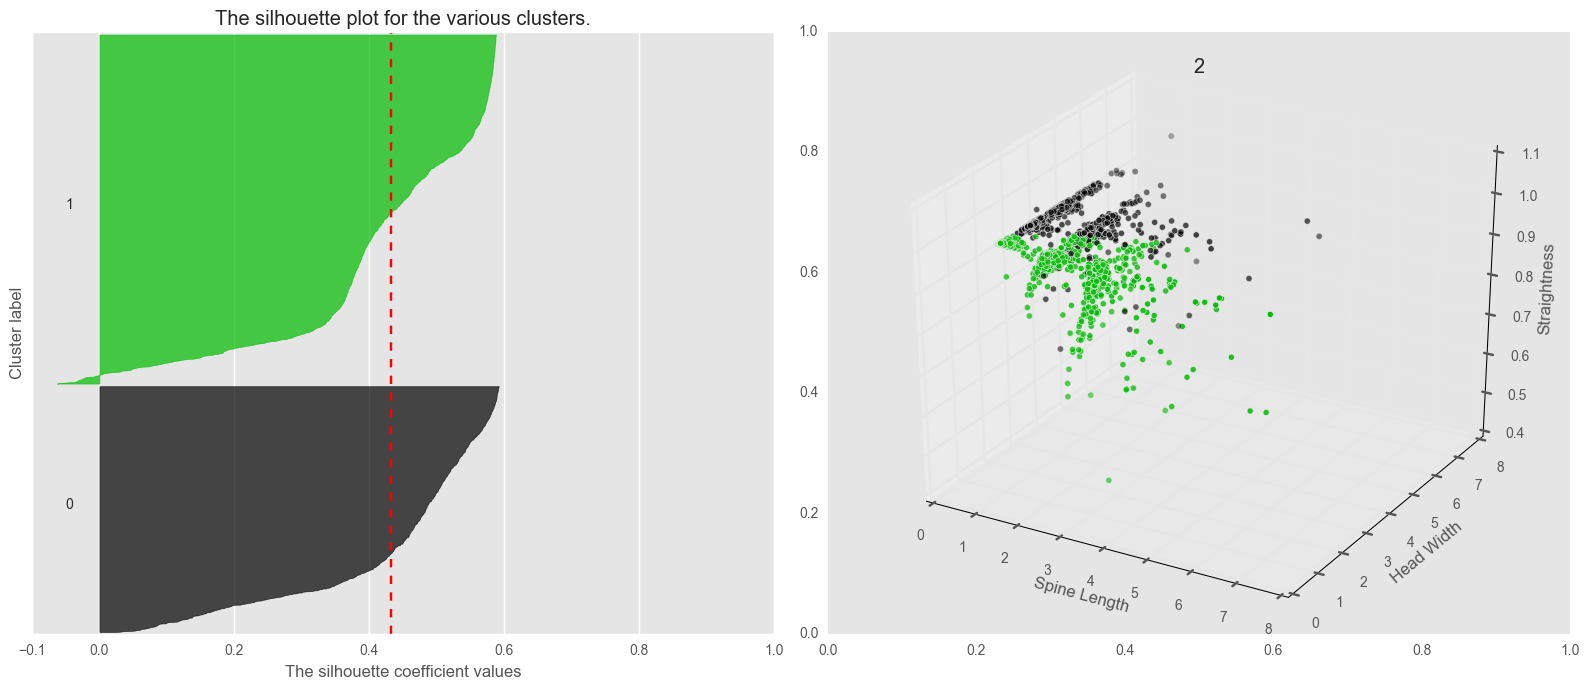

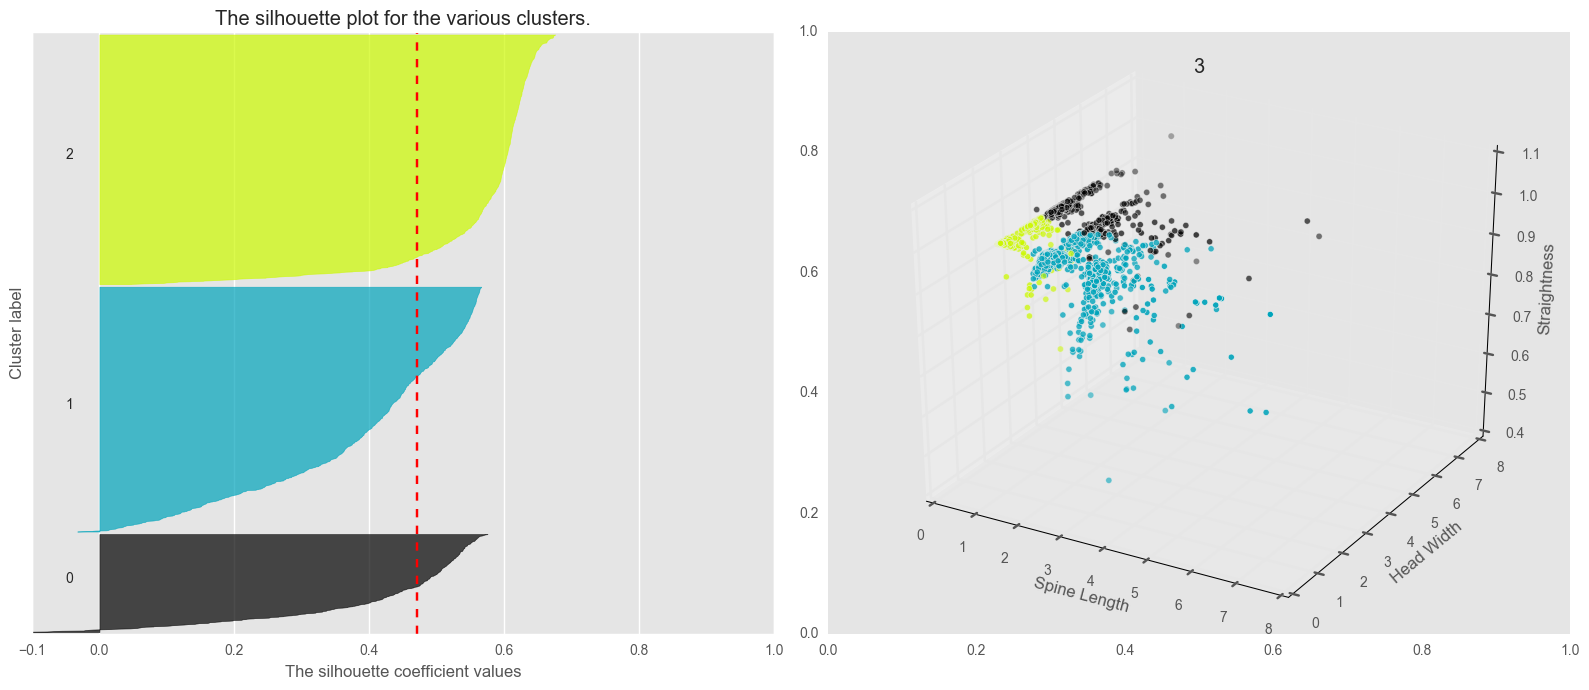

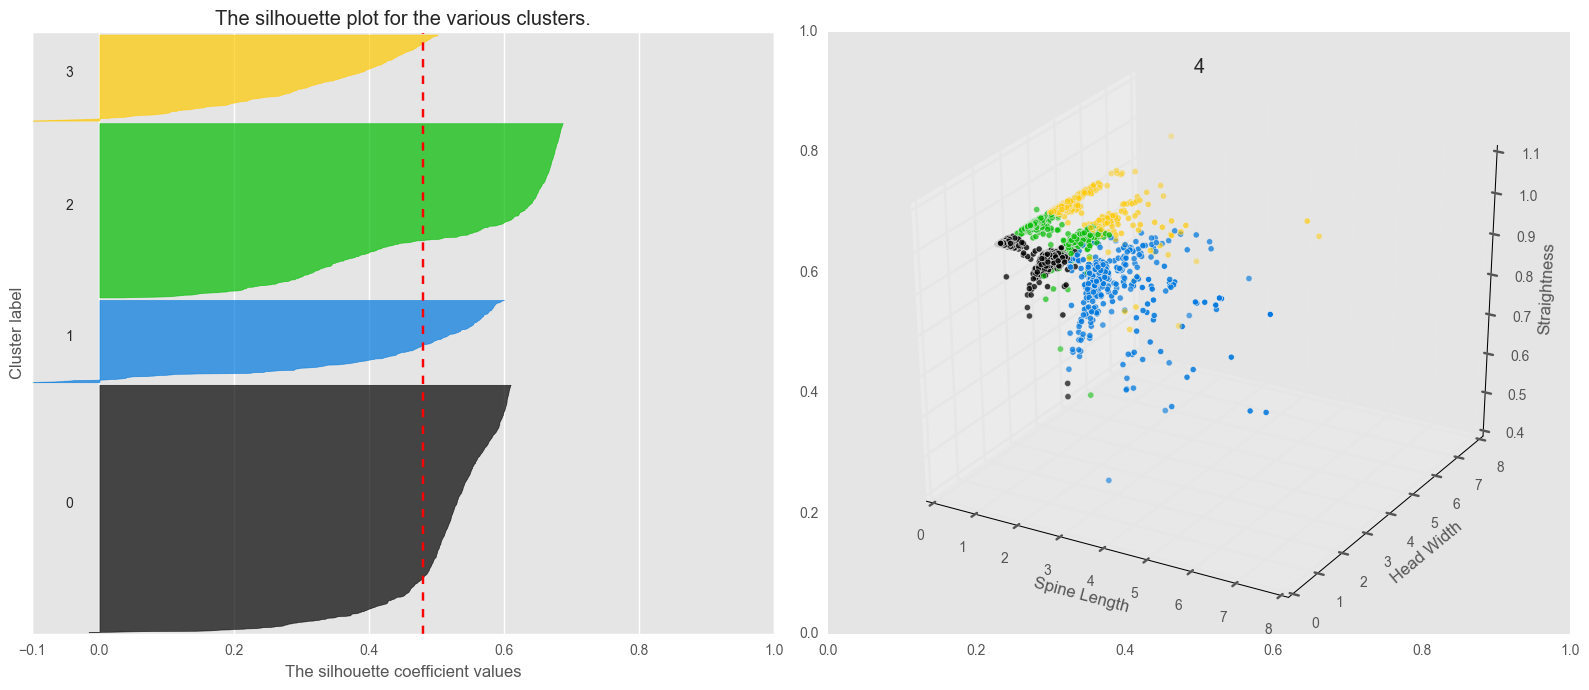

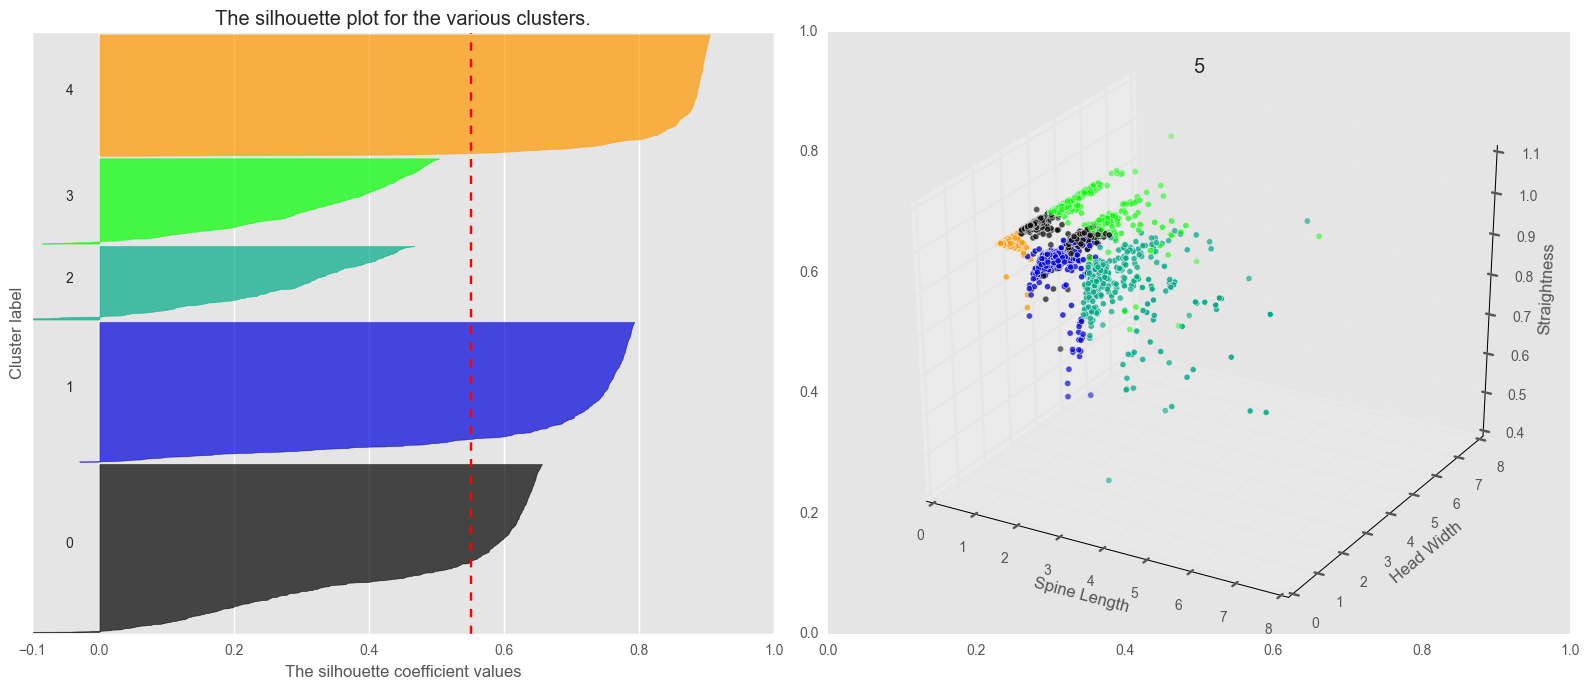

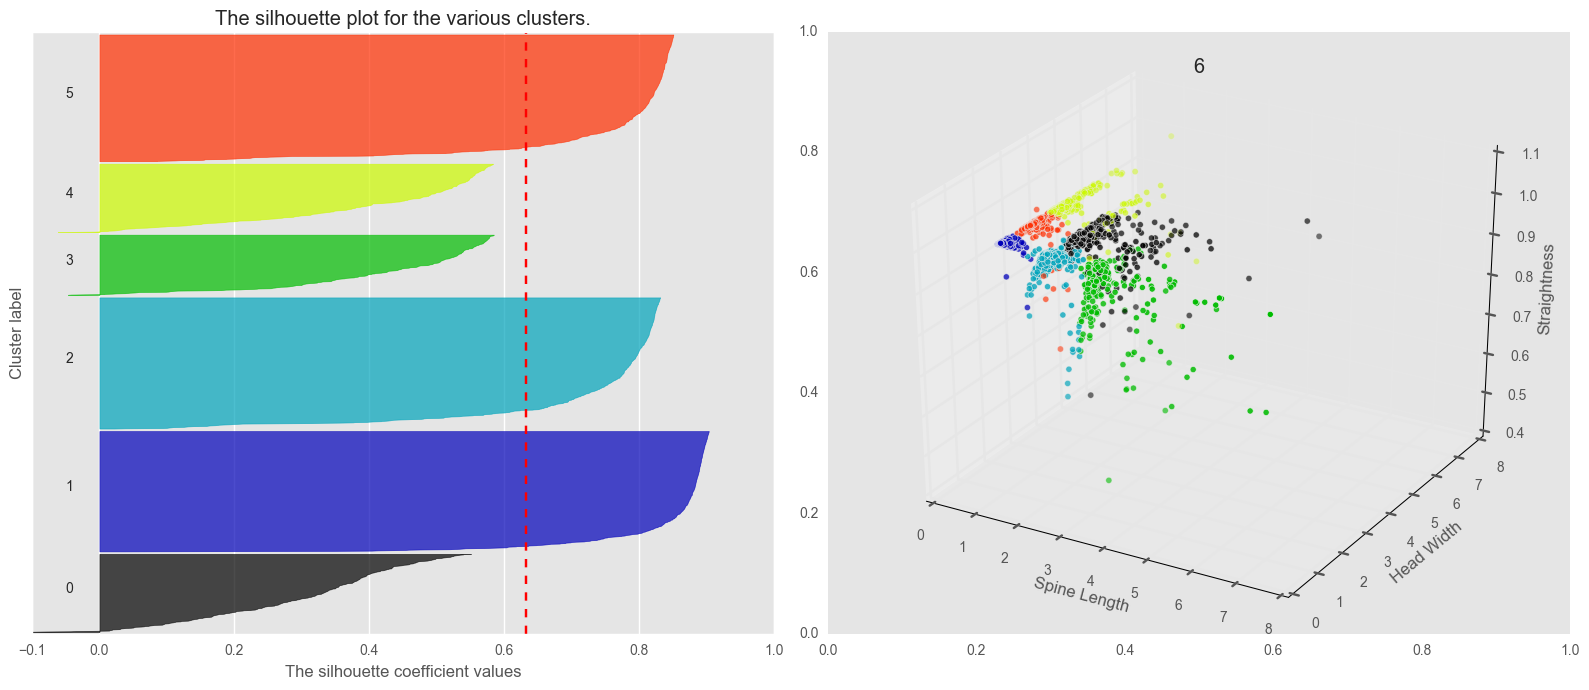

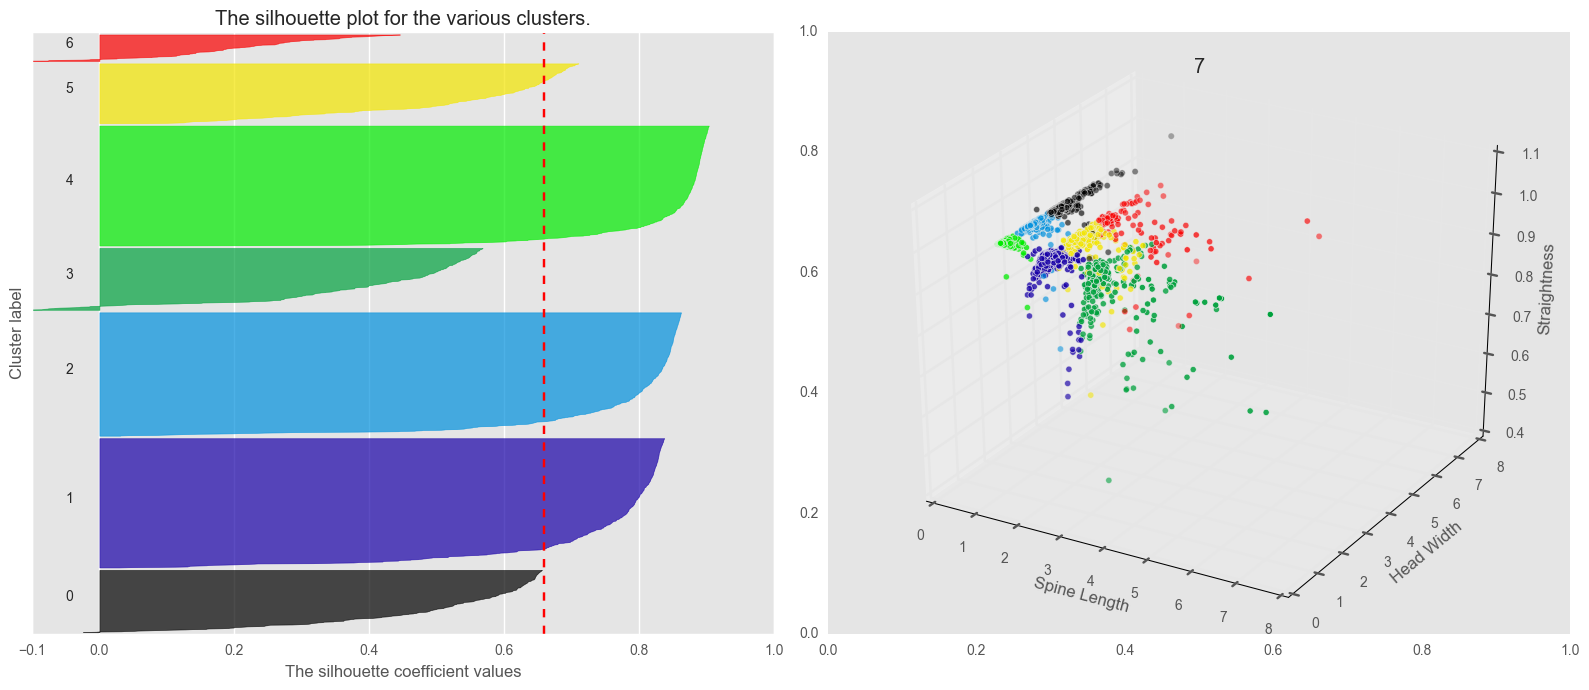

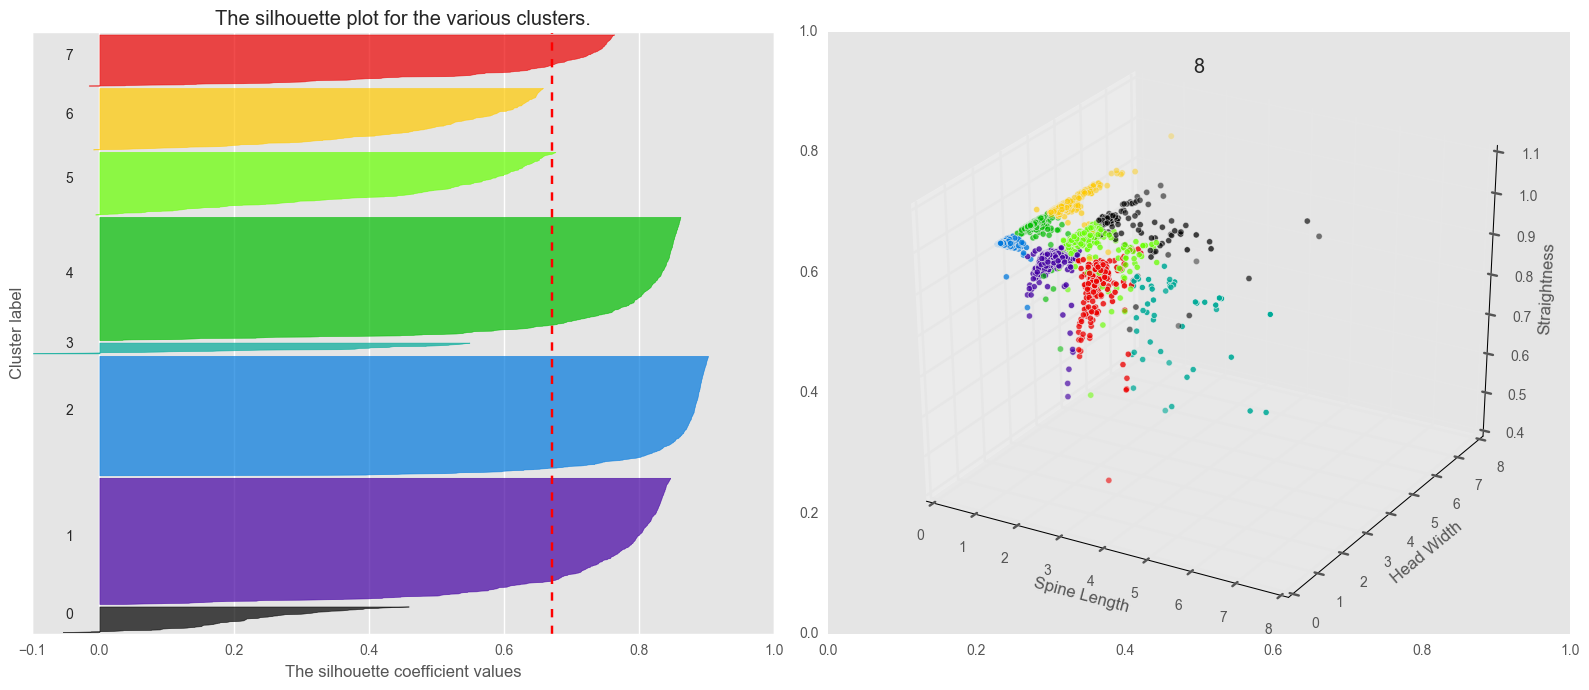

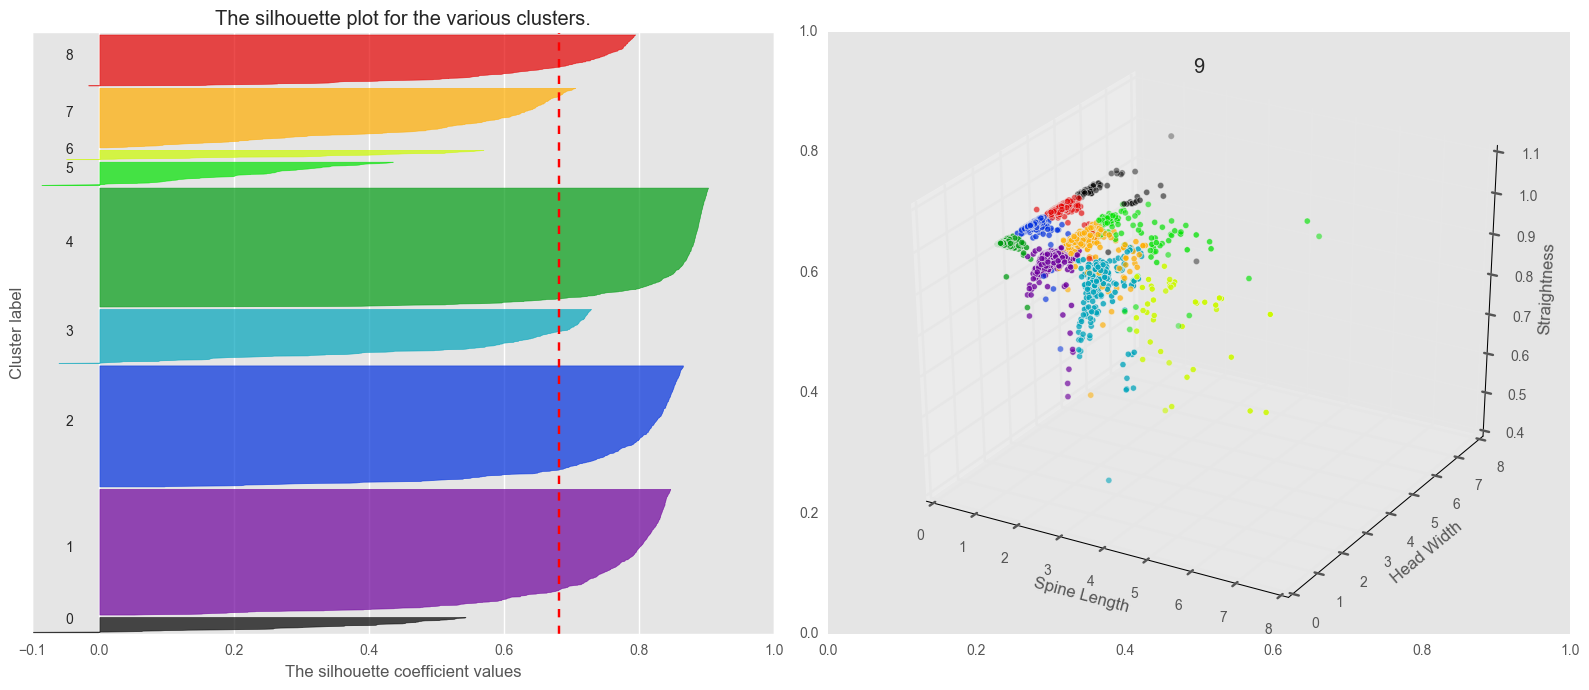

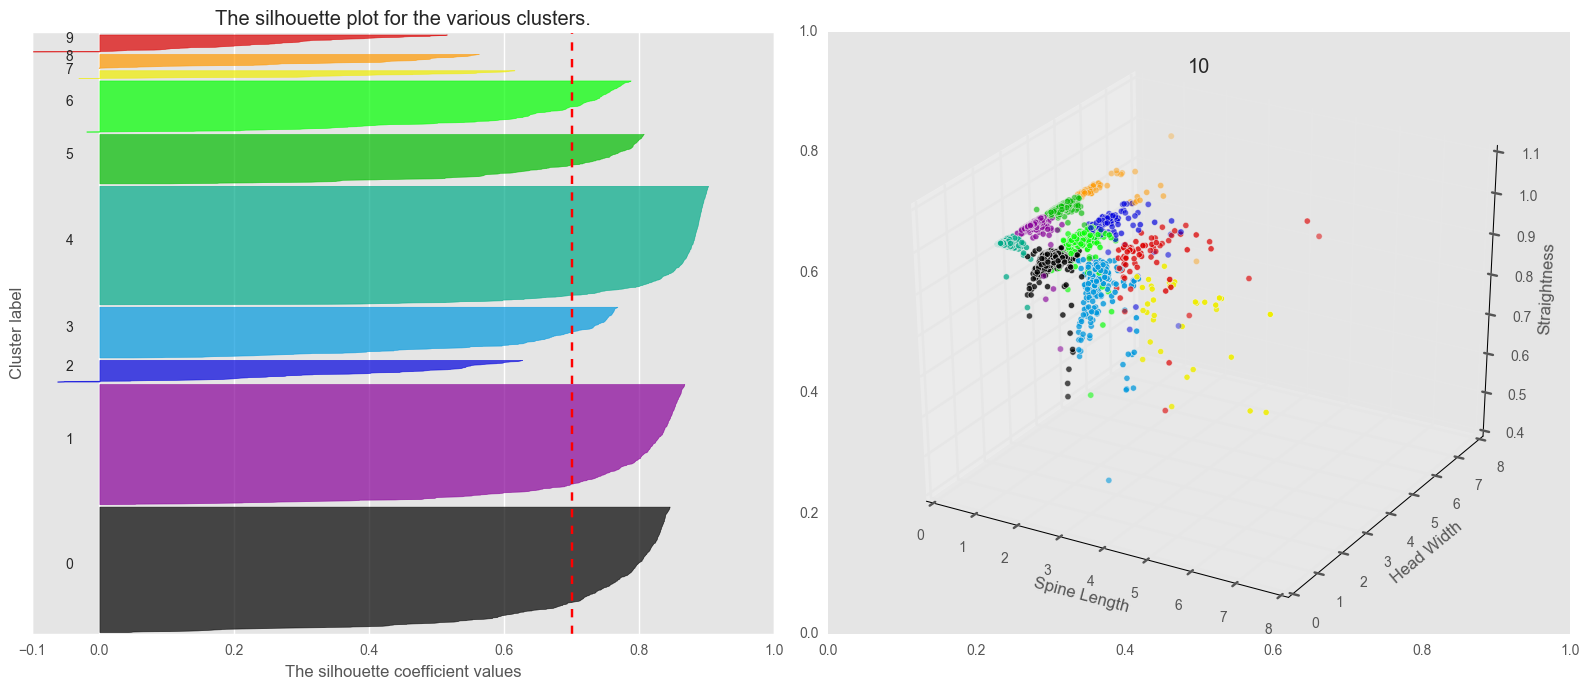

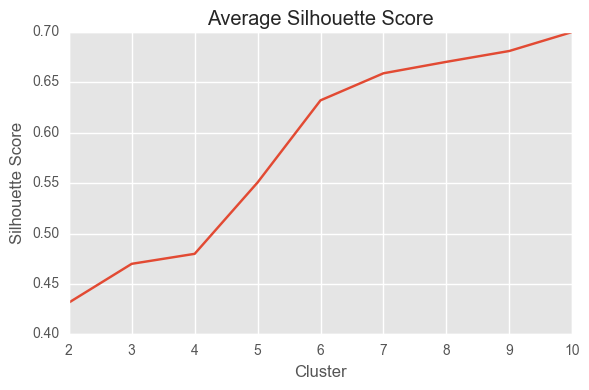

In [21]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import random
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = [2,3,4,5,6,7,8,9,10]
silhouette_avg_list = []

def plotclusters(whitened,kclusters):
    #plot clustering results on the scatterplot
    fig, ((ax1, ax)) = plt.subplots(1, 2, figsize=(16,7))


    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(whitened) + (kclusters + 1) * 10])    
    #centroids, clusters = scipy.cluster.vq.kmeans2(whitened, kclusters, iter=10000, minit='points')
    clusterer = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, n_jobs=-1, max_iter=1000)
    clusters = clusterer.fit_predict(whitened)
    
    silhouette_avg = silhouette_score(whitened, clusters)
    silhouette_avg_list.append(silhouette_avg)
    #print("For n_clusters =", kclusters)
    #print("The average silhouette_score is :\n", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(whitened, clusters)
    #print("The average sample_silhouette_values is :\n", sample_silhouette_values)
    y_lower = 10
    for i in range(kclusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / kclusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax = fig.add_subplot(122, projection='3d')
    
    x = whitened[:,0]
    y = whitened[:,1]
    z = whitened[:,2]
    
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    #colors = []
    
    #for index, cluster in enumerate(clusters):
        #colors.append(flatui[int(cluster)])
    colors = cm.spectral(clusters.astype(float) / kclusters)
    ax.scatter(x, y, z, c=colors, marker='o')
    
    ax.set_xlabel('Spine Length')
    ax.set_ylabel('Head Width')
    ax.set_zlabel('Straightness')
    plt.title(str(kclusters))
    plt.savefig("3dscatter-k"+str(kclusters)+".png")
    
    
# Running the loop    
for kclusters in clusters_range:
    plotclusters(clusteringRawInput,kclusters)
    
# Plotting silhouette    
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(clusters_range, silhouette_avg_list)
ax3.set_ylabel('Silhouette Score')
ax3.set_xlabel("Cluster")
plt.title('Average Silhouette Score')
plt.savefig("silhouette.png")